In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data, load_receptor_data
import os
import json
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import (
    linkage,
    fcluster,
    dendrogram,
    leaves_list,
    set_link_color_palette,
)
from matplotlib import colors
from nilearn.image import iter_img

/usr/local/lib/python3.9/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")
/usr/local/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [4]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
    )
    fc_group = load_data(
        os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
    )
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [5]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
    len(scm_nonzero.flatten())
)
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
    zero_rows_fc, fcm_thr, scm_nonzero
)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0)

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [6]:
initial_parcellation = nib.load(os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "initial_partition.nii.gz",
    ))
initial_parcellation_data = initial_parcellation.get_fdata()

In [7]:
tree_min = 2
tree_max = 200

g = 0.7
opt_level = 28
tree = json.loads(
                    open(
                        os.path.join(
                            project_path,
                            "data",
                            "results",
                            "n" + str(conn_size),
                            "tree_g_" + str(g) + ".json",
                        )
                    ).read()
)


['lightpink', 'steelblue', 'burlywood', 'olive', 'fuchsia', 'darkolivegreen', 'mediumspringgreen', 'indigo', 'mediumblue', 'khaki', 'chartreuse', 'slategray', 'rosybrown', 'orange', 'firebrick', 'lightslategray', 'peru', 'cadetblue', 'mediumpurple', 'coral', 'lightblue', 'grey', 'mediumturquoise', 'darkseagreen', 'teal', 'darkgrey', 'goldenrod', 'lightsalmon']


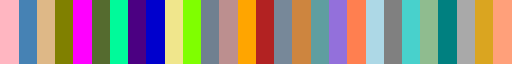

In [74]:
color_list = []
for name, hex in colors.cnames.items():
    rgb = colors.hex2color(hex)
    L = pow((pow(rgb[0], 2) + pow(rgb[1], 2) + pow(rgb[2], 2)), 0.5) / pow(3, 0.5)
    if L < 0.85:
        color_list.append(name)
color_list = list(np.random.choice(color_list, opt_level, replace=False))
cmap_rand = colors.ListedColormap(color_list)
print(color_list)
cmap_rand

/usr/local/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


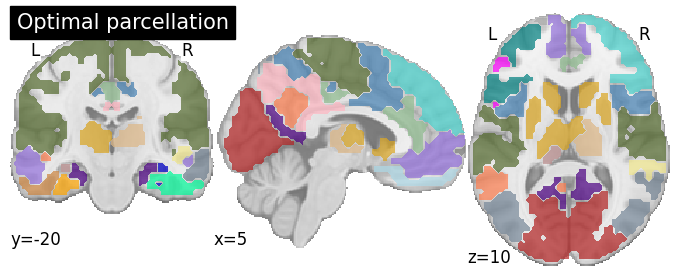

In [75]:
mni_bg = plotting.plot_anat(
    cut_coords=[5, -20, 10],
    black_bg=False,
    draw_cross=False,
    title="Optimal parcellation",
)
optimal_parcellation = nib.load(os.path.join(project_path, "data", "results", "n" + str(conn_size), "optimal_parcellation_4D.nii.gz"))
for mod, c in zip(iter_img(optimal_parcellation), color_list):
    mni_bg.add_contours(
        mod, linewidths=2.0, levels=[0.01], filled=True, alpha=0.7, colors=c
    )
plt.savefig(
    os.path.join(project_path, "data", "results", "figures", "opt_parcell_brain.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

/tmp/ipykernel_652117/3704262748.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(cc, "weighted", "correlation")


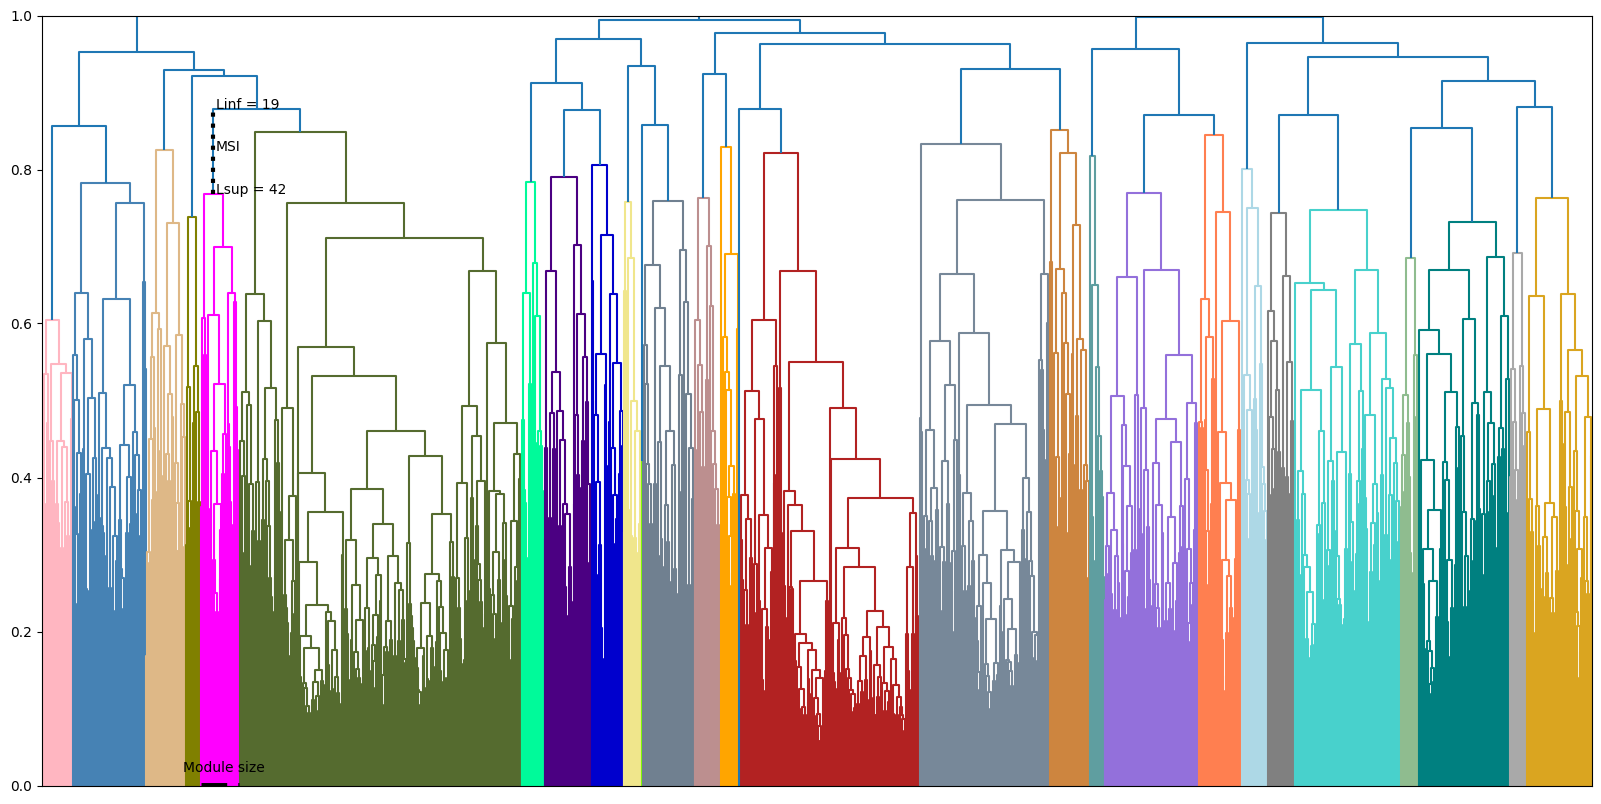

In [76]:
plt.rcParams["figure.figsize"] = [20, 10]

cc = matrix_fusion(g,fcm_bin, scm_bin)
Z = linkage(cc, "weighted", "correlation")
height_in_tree_sorted = Z[:, 2][::-1]

set_link_color_palette(color_list)
den = dendrogram(
    Z, color_threshold=height_in_tree_sorted[opt_level - 2], no_labels=True
)

# draw the meaning of duration for example in module 9

module_selected = 5

module_rois = tree["lvl_" + str(opt_level) + "_mod_" + str(module_selected)]
module_presence_in_tree = []
for l in range(2, 200):
    level, labels = level_from_tree(tree, l)
    for module in level:
        if module == module_rois:
            module_presence_in_tree.append(l)
            break

lvl_bf_module = min(module_presence_in_tree) - 2
lvl_af_module = max(module_presence_in_tree) - 1
min_height = height_in_tree_sorted[lvl_bf_module]
max_height = height_in_tree_sorted[lvl_af_module]

x_loc, y_loc = np.where(np.array(den["dcoord"]) == max_height)

x = den["icoord"][x_loc[2]][y_loc[2]]
plt.ylim(0, 1)
plt.axvline(x=x, ymin=max_height, ymax=min_height, color="k", ls=":", lw=3)
plt.annotate(
    "MSI",
    (x, (max_height + min_height) / 2),
    textcoords="offset points",
    xytext=(2, 0),
    ha="left",
    color="k",
)
plt.annotate(
    "Linf = " + str(lvl_bf_module),
    (x, min_height),
    textcoords="offset points",
    xytext=(2, 0),
    ha="left",
    color="k",
)
plt.annotate(
    "Lsup = " + str(lvl_af_module),
    (x, max_height),
    textcoords="offset points",
    xytext=(2, 0),
    ha="left",
    color="k",
)

# draw the meaning of module size for example in module 9
leaves = leaves_list(Z)
loc_in_tree = np.where(np.in1d(leaves, module_rois))[0]
x1 = den["icoord"][loc_in_tree[0]][0]
x2 = den["icoord"][loc_in_tree[-1]][0]
# draw a horizontal line in the bottom of the dendrogram from the first to the last leaf of the module
plt.axhline(
    y=0,
    xmin=loc_in_tree[0] / len(leaves),
    xmax=loc_in_tree[-1] / len(leaves),
    color="black",
    ls="--",
    lw=5,
)
plt.annotate(
    "Module size",
    ((x1 + x2) / 2, 0),
    textcoords="offset points",
    xytext=(0, 10),
    ha="center",
    rotation=0,
)
plt.savefig(
    os.path.join(project_path, "data", "results", "figures", "opt_parcell_tree.svg"),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

(21, 2140)


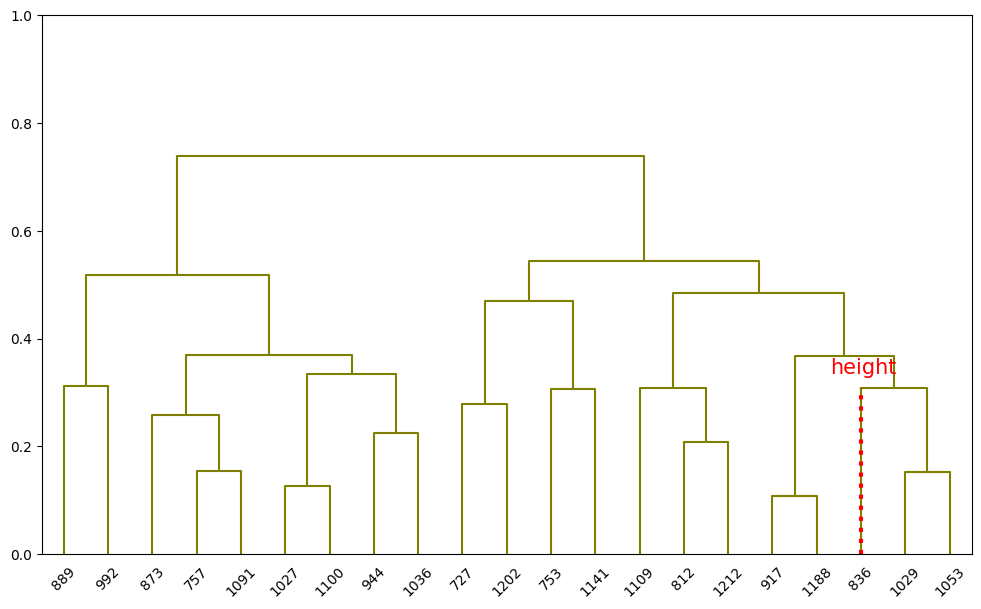

In [77]:
plt.rcParams["figure.figsize"] = [12, 7]

leaves = leaves_list(Z)
height_in_tree_nosorted = np.hstack((1, Z[:, 2]))
module_selected = 4

module_rois = tree["lvl_" + str(opt_level) + "_mod_" + str(module_selected)]
loc_in_tree = np.where(np.in1d(leaves, module_rois))[0]
subtree_color = den["leaves_color_list"][loc_in_tree[0]]

cc_mod = matrix_fusion(g, fcm_bin[module_rois, :], scm_bin[module_rois, :])
Z_mod = linkage(cc_mod, method, metric)
height_in_tree_sorted_mod = Z_mod[:, 2][::-1]
print(cc_mod.shape)

# Plot the new dendrogram
den_mod = dendrogram(
    Z_mod, color_threshold=0, above_threshold_color=subtree_color, labels=module_rois
)

leaves_first_list_sorted_mod = Z_mod[:, 0][::-1].astype(int)
leaves_second_list_sorted_mod = Z_mod[:, 1][::-1].astype(int)

# draw the meaning of height for roi 4, roi 4 is module_rois[4]
roi_selected = 4
idx_in_first_list_mod = np.where(leaves_first_list_sorted_mod == roi_selected)[0]
idx_in_second_list_mod = np.where(leaves_second_list_sorted_mod == roi_selected)[0]
if idx_in_first_list_mod.size > 0:
    roi_height = height_in_tree_sorted_mod[idx_in_first_list_mod[0]]
    x_loc, y_loc = np.where(np.array(den_mod["dcoord"]) == roi_height)
    x = den_mod["icoord"][x_loc[0]][y_loc[0]]
elif idx_in_second_list_mod.size > 0:
    roi_height = height_in_tree_sorted_mod[idx_in_second_list_mod[0]]
    x_loc, y_loc = np.where(np.array(den_mod["dcoord"]) == roi_height)
    x = den_mod["icoord"][x_loc[0]][y_loc[1]]


plt.ylim(0, 1)
plt.axvline(x=x, ymin=0, ymax=roi_height, color="r", ls=":", lw=3)
plt.annotate(
    "height",
    (x, roi_height),
    textcoords="offset points",
    xytext=(2, 10),
    ha="center",
    color="r",
    fontsize=15,
)
plt.savefig(
    os.path.join(
        project_path, "data", "results", "figures", "opt_parcell_mod_inset_example.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

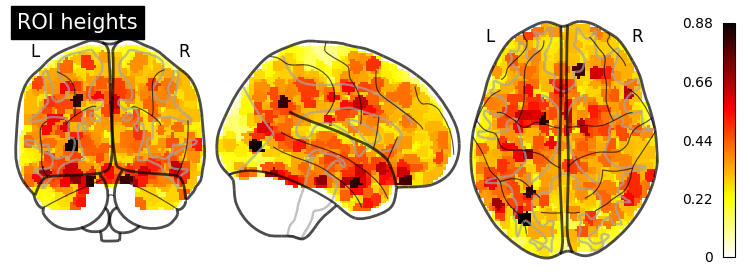

In [79]:
roi_break_heights = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
leaves_first_list_sorted = Z[:, 0][::-1].astype(int)
leaves_second_list_sorted = Z[:, 1][::-1].astype(int)

roi_heights = []
for roi in range(fcm_bin.shape[1]):
    idx_in_first_list = np.where(leaves_first_list_sorted == roi)[0]
    idx_in_second_list = np.where(leaves_second_list_sorted == roi)[0]
    if idx_in_first_list.size > 0:
        roi_break_heights = roi_break_heights + get_module_vol(
            initial_parcellation, roi, height_in_tree_sorted[idx_in_first_list[0]]
        )
        roi_heights.append(height_in_tree_sorted[idx_in_first_list[0]])
    elif idx_in_second_list.size > 0:
        roi_break_heights = roi_break_heights + get_module_vol(
            initial_parcellation, roi, height_in_tree_sorted[idx_in_second_list[0]]
        )
        roi_heights.append(height_in_tree_sorted[idx_in_second_list[0]])
    else:
        print("roi " + str(roi) + " not found")

plotting.plot_glass_brain(
    nib.Nifti1Image(roi_break_heights, affine=initial_parcellation.affine),
    colorbar=True,
    title="ROI heights",
)

nib.save(
    nib.Nifti1Image(roi_break_heights, affine=atlas_nonzero_img.affine),
    os.path.join(
        project_path,
        "data",
        "results",
        "n" + str(conn_size),
        "roi_breaks_heights.nii.gz",
    ),
)

Text(0, 0.5, 'ROI height')

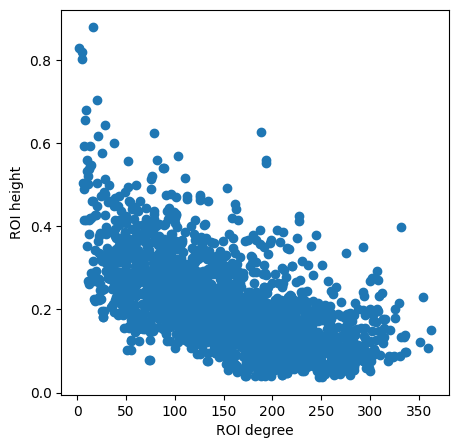

In [80]:
plt.rcParams["figure.figsize"] = [5, 5]

cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
strength_fullmat = cc.sum(axis=0, dtype=float)
plt.scatter(strength_fullmat, roi_heights)
plt.xlabel("ROI degree")
plt.ylabel("ROI height")

Text(0, 0.5, 'Multi-scale Index (MSI)')

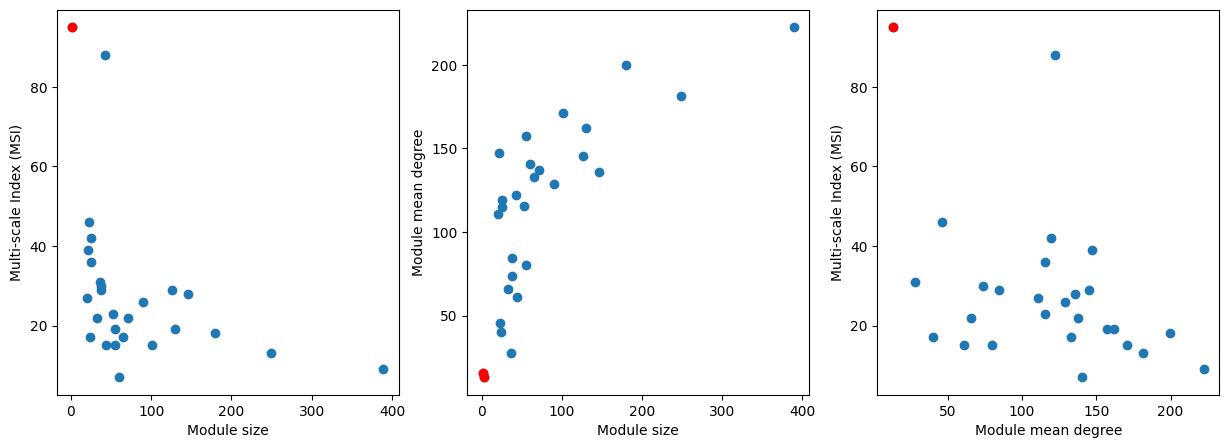

In [15]:
module_MSI = []
module_mean_degree = []
module_size = []

for module_indices in range(1, opt_level + 1):
    module_rois = tree["lvl_" + str(opt_level) + "_mod_" + str(module_indices)]
    module_mean_degree.append(strength_fullmat[module_rois].mean())
    module_presence_in_tree = []
    for l in range(2, 200):
        level, labels = level_from_tree(tree, l)
        for module in level:
            if module == module_rois:
                module_presence_in_tree.append(l)
                break
    if len(module_rois) > 1:
        module_MSI.append(len(module_presence_in_tree))
        module_size.append(len(module_rois))
    else:
        module_MSI.append(np.nan)  # sustituir el hardcodeo
        module_size.append(1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(module_size, module_MSI)
axs[0].scatter(
    np.array(module_size)[np.array(module_size) <= 2],
    np.array(module_MSI)[np.array(module_size) <= 2],
    color="r",
)
axs[0].set_xlabel("Module size")
axs[0].set_ylabel("Multi-scale Index (MSI)")
axs[1].scatter(module_size, module_mean_degree)
axs[1].scatter(
    np.array(module_size)[np.array(module_size) <= 2],
    np.array(module_mean_degree)[np.array(module_size) <= 2],
    color="r",
)
axs[1].set_xlabel("Module size")
axs[1].set_ylabel("Module mean degree")
axs[2].scatter(module_mean_degree, module_MSI)
axs[2].scatter(
    np.array(module_mean_degree)[np.array(module_size) <= 2],
    np.array(module_MSI)[np.array(module_size) <= 2],
    color="r",
)
axs[2].set_xlabel("Module mean degree")
axs[2].set_ylabel("Multi-scale Index (MSI)")

In [ ]:
plt.rcParams["figure.figsize"] = [5, 5]

module_heights = []
module_size = []
for module_indices in range(1, opt_level + 1):
    module_rois = tree["lvl_" + str(opt_level) + "_mod_" + str(module_indices)]
    module_size.append(len(module_rois))
    heights_from_first_list = height_in_tree_sorted[
        np.where(np.in1d(leaves_first_list_sorted, module_rois))[0]
    ]
    heights_from_second_list = height_in_tree_sorted[
        np.where(np.in1d(leaves_second_list_sorted, module_rois))[0]
    ]
    module_heights.append(
        np.mean(np.hstack((heights_from_first_list, heights_from_second_list)))
    )

plt.scatter(module_size, module_heights)
plt.scatter(
    np.array(module_size)[np.array(module_size) <= 2],
    np.array(module_heights)[np.array(module_size) <= 2],
    color="r",
)
plt.xlabel("Module size")
plt.ylabel("Module heights")

Text(0, 0.5, 'Module heights')

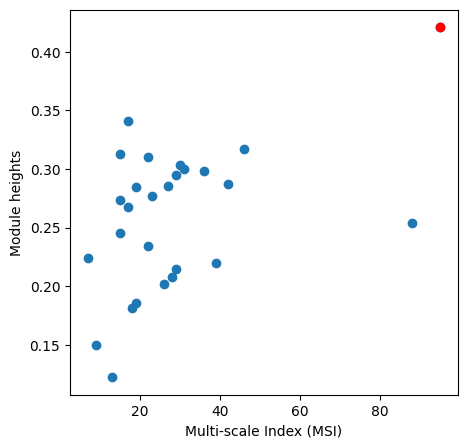

In [85]:
plt.rcParams["figure.figsize"] = [5, 5]

plt.scatter(module_MSI, module_heights)
plt.scatter(
    np.array(module_MSI)[np.array(module_size) <= 2],
    np.array(module_heights)[np.array(module_size) <= 2],
    color="r",
)
plt.xlabel("Multi-scale Index (MSI)")
plt.ylabel("Module heights")

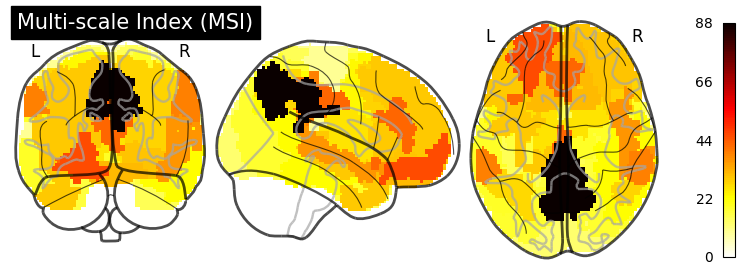

In [91]:
module_MSI_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
for idx, module_indices in enumerate(range(1, opt_level + 1)):
    module_rois = tree["lvl_" + str(opt_level) + "_mod_" + str(module_indices)]
    if len(module_rois) > 5:
        module_MSI_img = module_MSI_img + get_module_vol(
            initial_parcellation, module_rois, module_MSI[idx]
        )
plotting.plot_glass_brain(
    nib.Nifti1Image(module_MSI_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="Multi-scale Index (MSI)",
)
plt.savefig(
    os.path.join(
        project_path, "data", "results", "figures", "opt_parcell_module_MSI_brain.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)
nib.save(
    nib.Nifti1Image(module_MSI_img, affine=initial_parcellation.affine),
    os.path.join(project_path, "data", "results", "n" + str(conn_size), "MSI.nii.gz"),
)

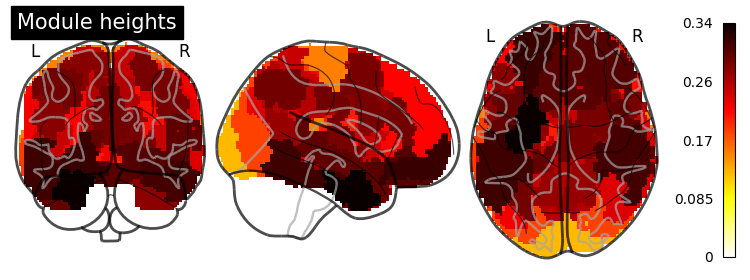

In [92]:
module_heights_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
for idx, module_indices in enumerate(range(1, opt_level + 1)):
    module_rois = tree["lvl_" + str(opt_level) + "_mod_" + str(module_indices)]
    if len(module_rois) > 5:
        module_heights_img = module_heights_img + get_module_vol(
            initial_parcellation, module_rois, module_heights[idx]
        )
plotting.plot_glass_brain(
    nib.Nifti1Image(module_heights_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="Module heights",
)
nib.save(
    nib.Nifti1Image(module_heights_img, affine=initial_parcellation.affine),
    os.path.join(
        project_path, "data", "results", "n" + str(conn_size), "module_heights.nii.gz"
    ),
)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "results",
        "figures",
        "opt_parcell_module_heights_brain.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

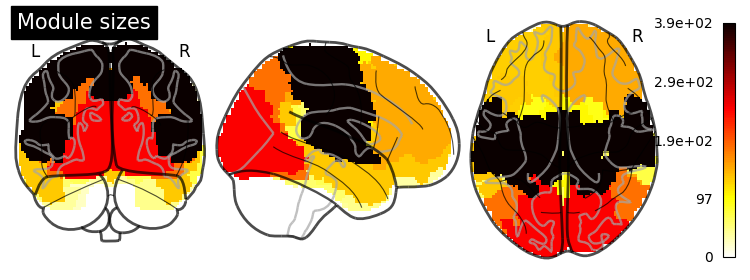

In [16]:
module_size_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
for idx, module_indices in enumerate(range(1, opt_level + 1)):
    module_rois = tree["lvl_" + str(opt_level) + "_mod_" + str(module_indices)]
    if len(module_rois) > 5:
        module_size_img = module_size_img + get_module_vol(
            initial_parcellation, module_rois, module_size[idx]
        )
plotting.plot_glass_brain(
    nib.Nifti1Image(module_size_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="Module sizes",
)
nib.save(
    nib.Nifti1Image(module_size_img, affine=initial_parcellation.affine),
    os.path.join(
        project_path, "data", "results", "n" + str(conn_size), "module_sizes.nii.gz"
    ),
)

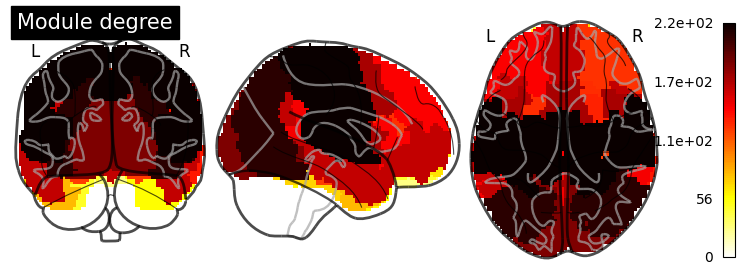

In [11]:
module_degree_img = np.zeros(
    (initial_parcellation.shape[0], initial_parcellation.shape[1], initial_parcellation.shape[2])
)
cc = abs(((g * abs(fcm_bin)) + ((1 - g) * scm_bin)))
strength_fullmat = cc.sum(axis=0, dtype=float)
for idx, module_indices in enumerate(range(1, opt_level + 1)):
    module_rois = tree["lvl_" + str(opt_level) + "_mod_" + str(module_indices)]
    module_degree = np.median(strength_fullmat[module_rois])
    if len(module_rois) > 5:
        module_degree_img = module_degree_img + get_module_vol(
            initial_parcellation, module_rois, module_degree
        )
plotting.plot_glass_brain(
    nib.Nifti1Image(module_degree_img, affine=initial_parcellation.affine),
    colorbar=True,
    title="Module degree",
)
nib.save(
    nib.Nifti1Image(module_degree_img, affine=initial_parcellation.affine),
    os.path.join(
        project_path, "data", "results", "n" + str(conn_size), "module_degree.nii.gz"
    ),
)